In [1]:
# This code works in Python 3.10.6
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
from typing import Dict, List, Union
import torch
import torch.nn.functional as F
from torch import nn
from torch_geometric.datasets import IMDB
import random
import torch
from torch import optim
from torch_geometric.data import HeteroData
import torch_geometric.transforms as T
import torch.nn.functional as F

from torch_geometric.nn import HANConv
import seaborn as sns
from collections import Counter
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
dataset = dataset = IMDB(root='./imdb_data')
data = dataset[0]
data

HeteroData(
  movie={
    x=[4278, 3066],
    y=[4278],
    train_mask=[4278],
    val_mask=[4278],
    test_mask=[4278]
  },
  director={ x=[2081, 3066] },
  actor={ x=[5257, 3066] },
  (movie, to, director)={ edge_index=[2, 4278] },
  (movie, to, actor)={ edge_index=[2, 12828] },
  (director, to, movie)={ edge_index=[2, 4278] },
  (actor, to, movie)={ edge_index=[2, 12828] }
)

In [3]:
#https://github.com/pyg-team/pytorch_geometric/blob/master/examples/hetero/han_imdb.py

dataset = IMDB(root='./imdb_data')

data = dataset[0]
print(data)


class HAN(nn.Module):
    def __init__(self, in_channels: Union[int, Dict[str, int]],
                 out_channels: int, hidden_channels=128, heads=8):
        super().__init__()
        self.han_conv = HANConv(in_channels, hidden_channels, heads=heads,
                                dropout=0.6, metadata=data.metadata())
        self.lin = nn.Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        out = self.han_conv(x_dict, edge_index_dict)
        out = self.lin(out['movie'])
        return out


model = HAN(in_channels=-1, out_channels=3)
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
data, model = data.to(device), model.to(device)

with torch.no_grad():  # Initialize lazy modules.
    out = model(data.x_dict, data.edge_index_dict)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=0.001)


def train() -> float:
    model.train()
    optimizer.zero_grad()
    out = model(data.x_dict, data.edge_index_dict)
    mask = data['movie'].train_mask
    loss = F.cross_entropy(out[mask], data['movie'].y[mask])
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test() -> List[float]:
    model.eval()
    pred = model(data.x_dict, data.edge_index_dict).argmax(dim=-1)

    accs = []
    for split in ['train_mask', 'val_mask', 'test_mask']:
        mask = data['movie'][split]
        acc = (pred[mask] == data['movie'].y[mask]).sum() / mask.sum()
        accs.append(float(acc))
    return accs


best_val_acc = 0
start_patience = patience = 100
for epoch in range(1, 100):

    loss = train()
    train_acc, val_acc, test_acc = test()
    if epoch%10==0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, '
              f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')

    if best_val_acc <= val_acc:
        patience = start_patience
        best_val_acc = val_acc
    else:
        patience -= 1

    if patience <= 0:
        print('Stopping training as validation accuracy did not improve '
              f'for {start_patience} epochs')
        break

HeteroData(
  movie={
    x=[4278, 3066],
    y=[4278],
    train_mask=[4278],
    val_mask=[4278],
    test_mask=[4278]
  },
  director={ x=[2081, 3066] },
  actor={ x=[5257, 3066] },
  (movie, to, director)={ edge_index=[2, 4278] },
  (movie, to, actor)={ edge_index=[2, 12828] },
  (director, to, movie)={ edge_index=[2, 4278] },
  (actor, to, movie)={ edge_index=[2, 12828] }
)
Epoch: 010, Loss: 0.7339, Train: 0.9050, Val: 0.5625, Test: 0.5193
Epoch: 020, Loss: 0.3129, Train: 0.9825, Val: 0.6125, Test: 0.5722
Epoch: 030, Loss: 0.1933, Train: 0.9975, Val: 0.6225, Test: 0.5690
Epoch: 040, Loss: 0.1652, Train: 1.0000, Val: 0.6300, Test: 0.5719
Epoch: 050, Loss: 0.1450, Train: 1.0000, Val: 0.6225, Test: 0.5687
Epoch: 060, Loss: 0.1230, Train: 1.0000, Val: 0.6300, Test: 0.5673
Epoch: 070, Loss: 0.1180, Train: 1.0000, Val: 0.6275, Test: 0.5679
Epoch: 080, Loss: 0.1183, Train: 1.0000, Val: 0.6200, Test: 0.5696
Epoch: 090, Loss: 0.0902, Train: 1.0000, Val: 0.6325, Test: 0.5707


In [4]:
def remap_indices(node_list):
    val_list = [*range(0, len(node_list), 1)]
    return dict(zip(node_list,val_list))  

In [5]:
def preprocess_edges(edgelist,node_list):
    res = [[node_list[i] for i, j in edgelist],[node_list[j] for i, j in edgelist]] 
    node_from = torch.tensor(res[0])
    node_to = torch.tensor(res[1])
    edges = torch.concat((node_from,node_to)).reshape(-1,len(node_from))
    return edges

In [6]:
all_edges = {}

In [7]:
def create_dataset(nodes,edges,movie_df,director_df,actor_df,node_id,df_graph):
    movie = np.asarray(movie_df.drop(columns=['class']))
    director = np.asarray(director_df)
    actor = np.asarray(actor_df)
   
    x_movie = torch.tensor(movie).to(dtype=torch.float32)
    y_movie = torch.tensor(np.array(movie_df["class"]), dtype=torch.long)
    x_director = torch.tensor(director).to(dtype=torch.float32)
    x_actor = torch.tensor(actor).to(dtype=torch.float32)
    
    #Edges
    source,dest =list(map(list, zip(*edges)))

    movie_to_director = []
    director_to_movie = []
    movie_to_actor = []
    actor_to_movie = []
    remaining_edges = []

    class_dict = {'Director':0, 'Actor':1, 'Movie':2}

    for i in range(len(edges)):

        if (df_graph.loc[df_graph['nodeId'] == source[i], 'class'].values[0] == class_dict['Movie']) and \
        (df_graph.loc[df_graph['nodeId'] == dest[i], 'class'].values[0] == class_dict['Director']):
                movie_to_director.append((int(source[i]),int(dest[i])))

        elif (df_graph.loc[df_graph['nodeId'] == source[i], 'class'].values[0] == class_dict['Director']) and \
            (df_graph.loc[df_graph['nodeId'] == dest[i], 'class'].values[0] == class_dict['Movie']):
                director_to_movie.append((int(source[i]),int(dest[i])))

        elif (df_graph.loc[df_graph['nodeId'] == source[i], 'class'].values[0] == class_dict['Movie']) and \
            (df_graph.loc[df_graph['nodeId'] == dest[i], 'class'].values[0] == class_dict['Actor']):
                movie_to_actor.append((int(source[i]),int(dest[i])))

        elif (df_graph.loc[df_graph['nodeId'] == source[i], 'class'].values[0] == class_dict['Actor']) and \
            (df_graph.loc[df_graph['nodeId'] == dest[i], 'class'].values[0] == class_dict['Movie']):
                actor_to_movie.append((int(source[i]),int(dest[i])))

        else:
            remaining_edges.append((int(source[i]),int(dest[i])))
            
    all_edges[node_id] = [*movie_to_director,*movie_to_actor,*director_to_movie,*actor_to_movie]
            
    movie = list(df_graph[df_graph['class'] == 2]['nodeId'])
    movie = [int(i) for i in movie]
    movie_nodes_mapping = remap_indices(movie)
    director = list(df_graph[df_graph['class'] == 0]['nodeId'])
    director = [int(i) for i in director]
    director_nodes_mapping = remap_indices(director)
    actor = list(df_graph[df_graph['class'] == 1]['nodeId'])
    actor = [int(i) for i in actor]
    actor_nodes_mapping = remap_indices(actor)


    node_list = {}
    for d in [movie_nodes_mapping, director_nodes_mapping, actor_nodes_mapping]:
        node_list.update(d)         

    #Create Hetero Data      
    small_graph = HeteroData({'movie':{'x': x_movie, 'y':y_movie}, 
                              'director':{'x': x_director},'actor':{'x': x_actor}})

    if movie_to_director:
        edge_index_movie_director = preprocess_edges(movie_to_director,node_list)
        small_graph['movie','to','director'].edge_index = edge_index_movie_director
        
    if director_to_movie:
        edge_index_director_movie = preprocess_edges(director_to_movie,node_list)
        small_graph['director','to','movie'].edge_index = edge_index_director_movie
    
    if actor_to_movie:
        edge_index_actor_movie = preprocess_edges(actor_to_movie,node_list)
        small_graph['actor','to','movie'].edge_index = edge_index_actor_movie
        
    if movie_to_actor:
        edge_index_movie_actor = preprocess_edges(movie_to_actor,node_list)
        small_graph['movie','to','actor'].edge_index = edge_index_movie_actor

    #Adding test mask for prediction
    transform = T.RandomNodeSplit(split='train_rest', num_val=0.0, num_test=1.0)
    small_graph = transform(small_graph)
            
    return small_graph

In [8]:
def evaluate_gnn(small_graph):
    with torch.no_grad():
        model.eval()
        #The pred is not used for accuracy, the softmax is used
        pred = model(small_graph.x_dict, small_graph.edge_index_dict).argmax(dim=-1)
        
        #Getting class prediction probabilities from the softmax layer
        softmax = model(small_graph.x_dict, small_graph.edge_index_dict).softmax(dim=-1)
        
        mask = small_graph['movie'].test_mask
        correct = (pred[mask] == small_graph['movie'].y[mask])
               
        print(small_graph)
        print('Prediction:',pred[mask])
        print('Ground Truth:',small_graph['movie'].y[mask])
        print(correct)
        print(softmax)
        
        correct_indices = [i for i, x in enumerate(correct.tolist()) if x]
        print('correct indices',correct_indices)
        
        #Taking softmax values of the nodes for which prediction is correct
        softmax_pred_list = [softmax.tolist()[i] for i in correct_indices]
        #print(softmax_pred_list)
        print('------------------------------------------------------------------')
        
        return softmax_pred_list, correct_indices

In [9]:
def apply_threshold(df):
    return df.applymap(lambda x: 0.0 if x<0.0 else 1.0)

In [10]:
def get_real_graph(size):
    real_graph = nx.Graph()
    if(size <= 5):
        real_graph = nx.read_gexf(real_graph_path+'real_G5.gexf')
    elif(size <= 10):
        real_graph = nx.read_gexf(real_graph_path+'real_G10.gexf')
    elif(size <= 15):
        real_graph = nx.read_gexf(real_graph_path+'real_G15.gexf')

    return real_graph

In [11]:
import os
import glob

softmax_dict = {}
nodefeature_dict = {}
graph_dict = {}
rootdir = '../syn_vae/imdb/'

real_graph_path = '../real_graphs/imdb/'
dir_list = []
for subdir, dirs,files in os.walk(rootdir):
    
    if files:
        graph_path = os.path.join(subdir, files[0])
        class_path = os.path.join(subdir, files[1])       
        feature_path = os.path.join(subdir, files[2])
        
        graph = nx.read_gexf(graph_path)
        filename = os.path.basename(graph_path)
        graph_id= filename.split('.')[0]
        #print(graph_id)
        
        nodeId_list = []
        
        for key, value in graph.nodes(data=True):
            nodeId_list.append(key)
            edges = [e for e in graph.edges]
            
        node_type_list = torch.load(class_path).detach().numpy()
        
        df_graph = pd.DataFrame()
        df_graph["nodeId"] = nodeId_list
        df_graph["class"] = node_type_list
        
        
        df_feature = pd.DataFrame(torch.load(feature_path).detach().numpy())        
        df_feature["class"] = node_type_list
        
        real_graph = get_real_graph(len(nodeId_list))
        
        node_label_list = []
        for n in real_graph.nodes:
            node_type = real_graph.nodes[n]["node_type"] 
            if node_type == 2:
                node_class = real_graph.nodes[n]["class"]
                node_label_list.append(node_class)
                
        
        movie_node_features = apply_threshold(df_feature[df_feature['class'] == 2].drop(['class'], axis = 1))

        
        if node_label_list:
            labels = []
            unique_labels = list(set(node_label_list))

            for i in range(0,len(movie_node_features)):
                labels.append(random.choice(unique_labels))
            
            movie_node_features['class']= labels

            director_node_features = df_feature[df_feature['class'] == 0].drop(['class'], axis = 1)
            actor_node_features = df_feature[df_feature['class'] == 1].drop(['class'], axis = 1)


            small_graph_data = create_dataset(nodeId_list,edges,
                                  movie_node_features,director_node_features,
                                  actor_node_features,graph_id,df_graph)
    
            edge_list = all_edges[graph_id]
            graph = nx.Graph(edge_list)
            if not nx.is_empty(graph) and nx.is_connected(graph):
            
                
                if (small_graph_data['movie'].x.nelement()!=0) and \
                (small_graph_data['actor','to','movie']) :
                    print(graph_path)
                    softmax, correct_indices = evaluate_gnn(small_graph_data)
                    softmax_dict[graph_id] = softmax
                    nodefeature_dict[graph_id]={'movie':small_graph_data['movie'].x[correct_indices],
                                         'director':small_graph_data['director'].x,
                                         'actor':small_graph_data['actor'].x}
                    graph_dict[graph_id]=df_graph

        
        

../syn_vae/imdb/sync101415233229/sync101415233229_G5.gexf
HeteroData(
  movie={
    x=[2, 3066],
    y=[2],
    train_mask=[2],
    val_mask=[2],
    test_mask=[2]
  },
  director={ x=[0, 3066] },
  actor={ x=[3, 3066] },
  (actor, to, movie)={ edge_index=[2, 1] },
  (movie, to, actor)={ edge_index=[2, 1] }
)
Prediction: tensor([2, 1])
Ground Truth: tensor([2, 2])
tensor([ True, False])
tensor([[3.3169e-01, 3.2573e-01, 3.4257e-01],
        [9.9906e-04, 9.9863e-01, 3.6818e-04]])
correct indices [0]
------------------------------------------------------------------
../syn_vae/imdb/sync105908233241/sync105908233241_G5.gexf
HeteroData(
  movie={
    x=[2, 3066],
    y=[2],
    train_mask=[2],
    val_mask=[2],
    test_mask=[2]
  },
  director={ x=[0, 3066] },
  actor={ x=[3, 3066] },
  (actor, to, movie)={ edge_index=[2, 1] },
  (movie, to, actor)={ edge_index=[2, 1] }
)
Prediction: tensor([2, 1])
Ground Truth: tensor([2, 2])
tensor([ True, False])
tensor([[0.3317, 0.3257, 0.3426],
      

../syn_vae/imdb/sync219685233244/sync219685233244_G4.gexf
HeteroData(
  movie={
    x=[1, 3066],
    y=[1],
    train_mask=[1],
    val_mask=[1],
    test_mask=[1]
  },
  director={ x=[0, 3066] },
  actor={ x=[3, 3066] },
  (actor, to, movie)={ edge_index=[2, 1] }
)
Prediction: tensor([0])
Ground Truth: tensor([2])
tensor([False])
tensor([[0.7632, 0.0031, 0.2337]])
correct indices []
------------------------------------------------------------------
../syn_vae/imdb/sync484715233249/sync484715233249_G5.gexf
HeteroData(
  movie={
    x=[3, 3066],
    y=[3],
    train_mask=[3],
    val_mask=[3],
    test_mask=[3]
  },
  director={ x=[1, 3066] },
  actor={ x=[1, 3066] },
  (director, to, movie)={ edge_index=[2, 1] },
  (actor, to, movie)={ edge_index=[2, 2] },
  (movie, to, actor)={ edge_index=[2, 1] }
)
Prediction: tensor([2, 1, 1])
Ground Truth: tensor([2, 2, 2])
tensor([ True, False, False])
tensor([[0.3317, 0.3257, 0.3426],
        [0.0511, 0.8107, 0.1381],
        [0.1752, 0.7539, 0.0

../syn_vae/imdb/sync372529233244/sync372529233244_G5.gexf
HeteroData(
  movie={
    x=[2, 3066],
    y=[2],
    train_mask=[2],
    val_mask=[2],
    test_mask=[2]
  },
  director={ x=[2, 3066] },
  actor={ x=[1, 3066] },
  (director, to, movie)={ edge_index=[2, 1] },
  (actor, to, movie)={ edge_index=[2, 2] }
)
Prediction: tensor([1, 1])
Ground Truth: tensor([2, 2])
tensor([False, False])
tensor([[0.0092, 0.9724, 0.0185],
        [0.0097, 0.9819, 0.0084]])
correct indices []
------------------------------------------------------------------
../syn_vae/imdb/sync379202233237/sync379202233237_G5.gexf
HeteroData(
  movie={
    x=[2, 3066],
    y=[2],
    train_mask=[2],
    val_mask=[2],
    test_mask=[2]
  },
  director={ x=[1, 3066] },
  actor={ x=[2, 3066] },
  (actor, to, movie)={ edge_index=[2, 1] },
  (movie, to, actor)={ edge_index=[2, 1] }
)
Prediction: tensor([2, 1])
Ground Truth: tensor([2, 2])
tensor([ True, False])
tensor([[3.3169e-01, 3.2573e-01, 3.4257e-01],
        [3.8990e

../syn_vae/imdb/sync72934233238/sync72934233238_G5.gexf
HeteroData(
  movie={
    x=[2, 3066],
    y=[2],
    train_mask=[2],
    val_mask=[2],
    test_mask=[2]
  },
  director={ x=[2, 3066] },
  actor={ x=[1, 3066] },
  (director, to, movie)={ edge_index=[2, 1] },
  (actor, to, movie)={ edge_index=[2, 1] },
  (movie, to, actor)={ edge_index=[2, 1] }
)
Prediction: tensor([2, 2])
Ground Truth: tensor([2, 2])
tensor([True, True])
tensor([[0.3317, 0.3257, 0.3426],
        [0.2987, 0.0674, 0.6339]])
correct indices [0, 1]
------------------------------------------------------------------
../syn_vae/imdb/sync735912233245/sync735912233245_G5.gexf
HeteroData(
  movie={
    x=[2, 3066],
    y=[2],
    train_mask=[2],
    val_mask=[2],
    test_mask=[2]
  },
  director={ x=[1, 3066] },
  actor={ x=[2, 3066] },
  (actor, to, movie)={ edge_index=[2, 1] },
  (movie, to, actor)={ edge_index=[2, 1] }
)
Prediction: tensor([2, 1])
Ground Truth: tensor([2, 2])
tensor([ True, False])
tensor([[3.3169e-0

../syn_vae/imdb/sync256703233249/sync256703233249_G5.gexf
HeteroData(
  movie={
    x=[2, 3066],
    y=[2],
    train_mask=[2],
    val_mask=[2],
    test_mask=[2]
  },
  director={ x=[1, 3066] },
  actor={ x=[2, 3066] },
  (actor, to, movie)={ edge_index=[2, 1] },
  (movie, to, actor)={ edge_index=[2, 1] }
)
Prediction: tensor([2, 1])
Ground Truth: tensor([2, 2])
tensor([ True, False])
tensor([[0.3317, 0.3257, 0.3426],
        [0.0530, 0.9455, 0.0015]])
correct indices [0]
------------------------------------------------------------------
../syn_vae/imdb/sync258608233308/sync258608233308_G10.gexf
HeteroData(
  movie={
    x=[2, 3066],
    y=[2],
    train_mask=[2],
    val_mask=[2],
    test_mask=[2]
  },
  director={ x=[5, 3066] },
  actor={ x=[3, 3066] },
  (director, to, movie)={ edge_index=[2, 1] },
  (actor, to, movie)={ edge_index=[2, 1] },
  (movie, to, actor)={ edge_index=[2, 2] }
)
Prediction: tensor([1, 1])
Ground Truth: tensor([0, 0])
tensor([False, False])
tensor([[0.2066,

../syn_vae/imdb/sync655675233353/sync655675233353_G15.gexf
HeteroData(
  movie={
    x=[2, 3066],
    y=[2],
    train_mask=[2],
    val_mask=[2],
    test_mask=[2]
  },
  director={ x=[2, 3066] },
  actor={ x=[11, 3066] },
  (actor, to, movie)={ edge_index=[2, 3] }
)
Prediction: tensor([2, 2])
Ground Truth: tensor([2, 2])
tensor([True, True])
tensor([[0.1545, 0.1130, 0.7325],
        [0.0071, 0.0089, 0.9839]])
correct indices [0, 1]
------------------------------------------------------------------
../syn_vae/imdb/sync396923233234/sync396923233234_G4.gexf
HeteroData(
  movie={
    x=[2, 3066],
    y=[2],
    train_mask=[2],
    val_mask=[2],
    test_mask=[2]
  },
  director={ x=[1, 3066] },
  actor={ x=[1, 3066] },
  (director, to, movie)={ edge_index=[2, 1] },
  (actor, to, movie)={ edge_index=[2, 1] },
  (movie, to, actor)={ edge_index=[2, 1] }
)
Prediction: tensor([2, 1])
Ground Truth: tensor([2, 2])
tensor([ True, False])
tensor([[0.3317, 0.3257, 0.3426],
        [0.0726, 0.4793,

../syn_vae/imdb/sync800582233228/sync800582233228_G5.gexf
HeteroData(
  movie={
    x=[2, 3066],
    y=[2],
    train_mask=[2],
    val_mask=[2],
    test_mask=[2]
  },
  director={ x=[1, 3066] },
  actor={ x=[2, 3066] },
  (actor, to, movie)={ edge_index=[2, 1] },
  (movie, to, actor)={ edge_index=[2, 1] }
)
Prediction: tensor([2, 1])
Ground Truth: tensor([2, 2])
tensor([ True, False])
tensor([[3.3169e-01, 3.2573e-01, 3.4257e-01],
        [6.3643e-04, 9.9333e-01, 6.0293e-03]])
correct indices [0]
------------------------------------------------------------------
../syn_vae/imdb/sync803036233441/sync803036233441_G13.gexf
HeteroData(
  movie={
    x=[2, 3066],
    y=[2],
    train_mask=[2],
    val_mask=[2],
    test_mask=[2]
  },
  director={ x=[3, 3066] },
  actor={ x=[8, 3066] },
  (movie, to, director)={ edge_index=[2, 1] },
  (director, to, movie)={ edge_index=[2, 2] },
  (actor, to, movie)={ edge_index=[2, 2] },
  (movie, to, actor)={ edge_index=[2, 1] }
)
Prediction: tensor([1, 0

In [12]:
print("No. of graphs evaluated: ",len(softmax_dict))

No. of graphs evaluated:  89


In [13]:
#Getting the list of predictions for each class
prob_class0_dict = {}
prob_class1_dict = {}
prob_class2_dict = {}

for nodeid in softmax_dict:
    

    if len(softmax_dict[nodeid]) > 0:
        list0= []
        list1= []
        list2= []


        for prob in softmax_dict[nodeid]:        
            list0.append(prob[0])        
            list1.append(prob[1]) 
            list2.append(prob[2]) 


     #Taking max probability of all nodes of each class in a graph
    if len(list0) != 0:
        prob_class0_dict[nodeid]=max(list0)
    if len(list1) != 0:
        prob_class1_dict[nodeid]=max(list1)
    if len(list2) != 0:
        prob_class2_dict[nodeid]=max(list2)

In [14]:
max_pred0 = max(prob_class0_dict.values())
max_pred1 = max(prob_class1_dict.values())
max_pred2 = max(prob_class2_dict.values())

In [15]:
class0_graphid = max(prob_class0_dict, key=prob_class0_dict.get)
class1_graphid = max(prob_class1_dict, key=prob_class1_dict.get)
class2_graphid = max(prob_class2_dict, key=prob_class2_dict.get)

In [16]:
print(class0_graphid)
print(class1_graphid)
print(class2_graphid)

sync66614233322_G10
sync918939233300_G10
sync845965233420_G12


In [17]:
def plot_graph(graphid, max_pred,nodetype,edges,graph):

    classes = []
    G = nx.Graph(edges)
    df_graph = graph_dict[graphid]
    for g in G.nodes():
        #print(g)
        #print(df_graph.loc[g]['class'])
        if df_graph.loc[df_graph['nodeId'] == str(g), 'class'].values[0] == 0:
            classes.append(0)
        if df_graph.loc[df_graph['nodeId'] == str(g), 'class'].values[0] == 1:
            classes.append(1)
        if df_graph.loc[df_graph['nodeId'] == str(g), 'class'].values[0]== 2:
            classes.append(2)
   
    
    color_class_map = {0: 'blue', 1: 'red', 2: 'darkgreen'}
    
    nx.set_node_attributes(G, dict(zip(G.nodes(), classes)), 'class')
    
    print('Number of nodes: ',G.number_of_nodes())
    print('graph id: ',graphid)
    print(f'Max pred probability for class {nodetype} is {max_pred}')

    nx.draw(G, 
    with_labels=False, node_color=[color_class_map[node[1]['class']] 
                        for node in G.nodes(data=True)], 
            node_size=100,
        font_color='black')
    plt.show()

In [18]:
def index_2d(prob_list, v):
    for i, x in enumerate(prob_list):
        if v in x:
            return (i, x.index(v))

In [19]:
def count_plot(feat_list):
    fig, ax = plt.subplots(figsize=(7, 7))
    sns.countplot(x=0,ax=ax,data=pd.DataFrame(feat_list),width=0.3)
    for i in ax.containers:
        ax.bar_label(i,fontsize=15)
    plt.xticks(fontsize=15)

    plt.yticks(fontsize=15)
    plt.xlabel('feature values',fontsize=15)
    plt.ylabel('feature count',fontsize=15)

    plt.show()

Number of nodes:  7
graph id:  sync66614233322_G10
Max pred probability for class 0 is 0.9502894878387451


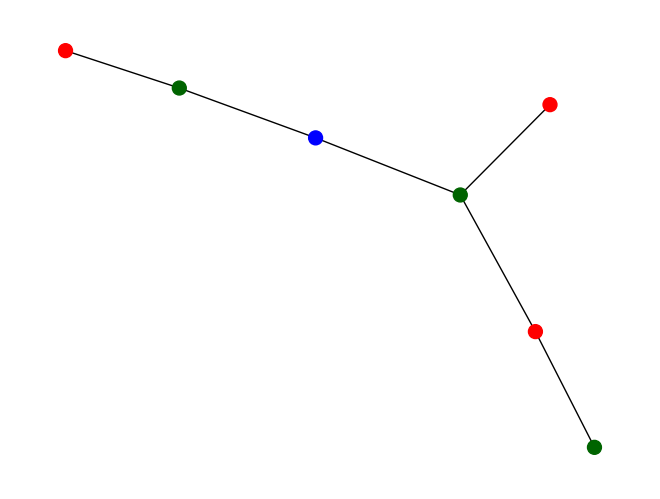

In [20]:
explanation_graph0 = plot_graph(class0_graphid, max_pred0, 0, all_edges[class0_graphid],graph_dict[class0_graphid])

In [21]:
ind= index_2d(softmax_dict[class0_graphid], max_pred0)[0]
list0= nodefeature_dict[class0_graphid]['movie'].numpy()[ind]
Counter(list0)

Counter({1.0: 1568, 0.0: 1498})

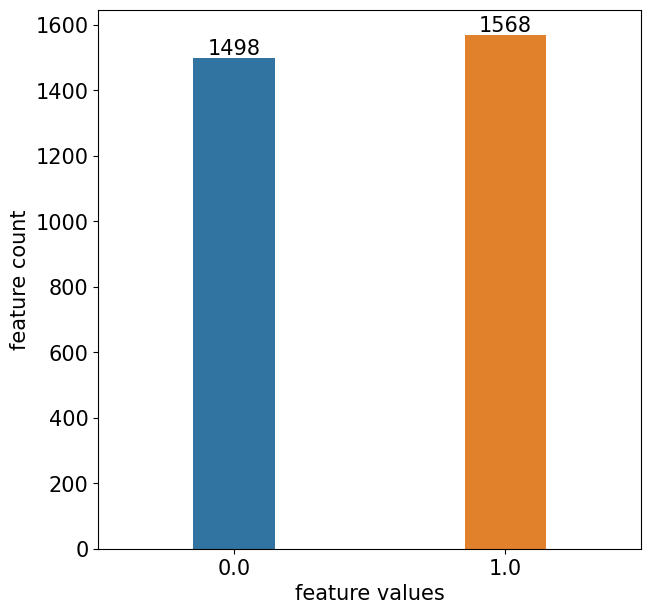

In [22]:
count_plot(list0)

Number of nodes:  3
graph id:  sync918939233300_G10
Max pred probability for class 1 is 0.468096524477005


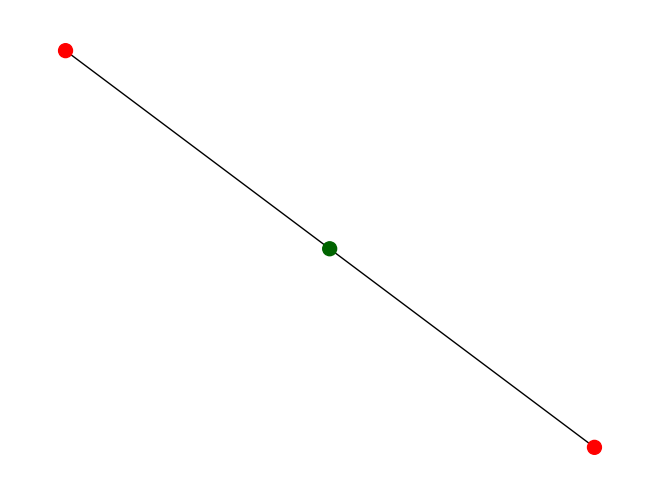

In [23]:
explanation_graph1 = plot_graph(class1_graphid, max_pred1, 1, all_edges[class1_graphid],graph_dict[class1_graphid])

In [24]:
ind= index_2d(softmax_dict[class1_graphid], max_pred1)[0]
list1= nodefeature_dict[class1_graphid]['movie'].numpy()[ind]
Counter(list1)

Counter({0.0: 1582, 1.0: 1484})

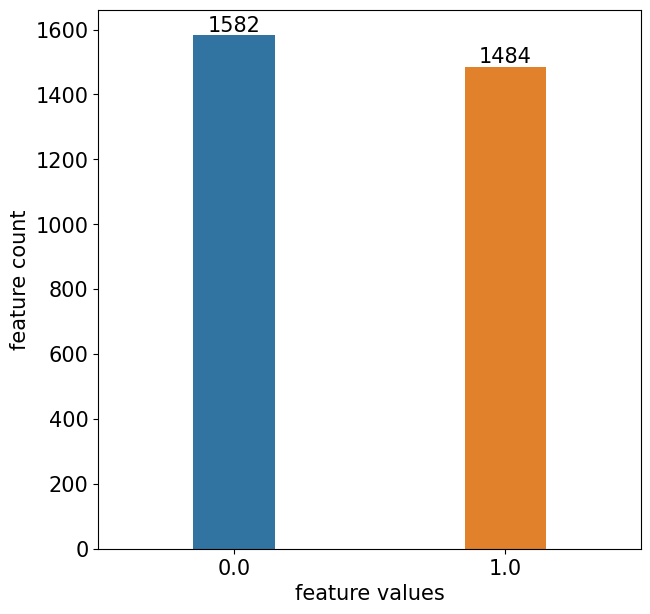

In [25]:
count_plot(list1)

Number of nodes:  7
graph id:  sync845965233420_G12
Max pred probability for class 2 is 0.99440997838974


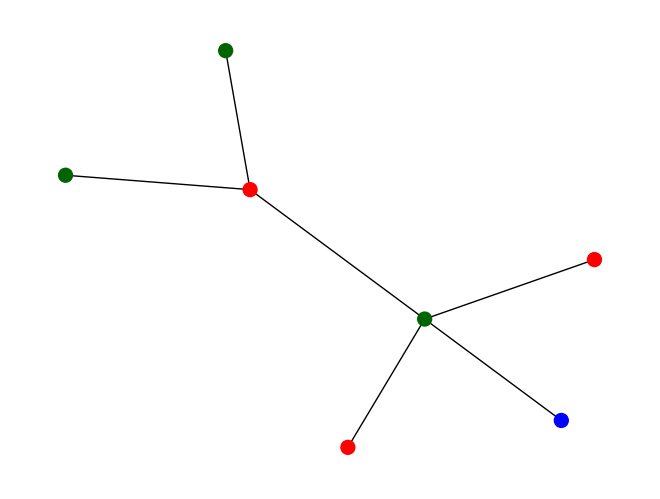

In [26]:
explanation_graph2 = plot_graph(class2_graphid, max_pred2, 2, all_edges[class2_graphid],graph_dict[class2_graphid])

In [27]:
ind= index_2d(softmax_dict[class2_graphid], max_pred2)[0]
list2= nodefeature_dict[class2_graphid]['movie'].numpy()[ind]
Counter(list2)

Counter({1.0: 1570, 0.0: 1496})

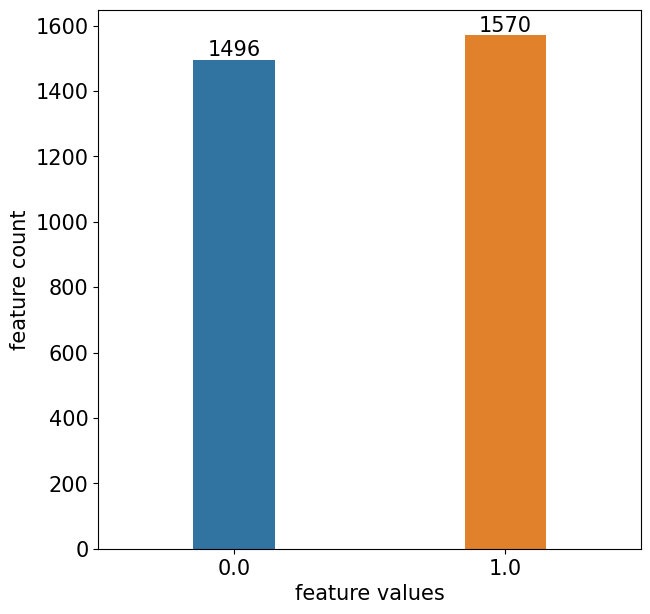

In [28]:
count_plot(list2)

In [29]:
def print_stat_cont_features(df):
    #print('summary',df.describe())
    print('mean',df.stack().mean())
    print('std dev',df.stack().std())

In [30]:
def plot_node_feat(imp_feat):
    sns.distplot(imp_feat,color= 'orange',hist= False)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.ylabel('Density',fontsize=15)

    plt.show() 

In [31]:
#Actor
actor0_df = pd.DataFrame(nodefeature_dict[class0_graphid]['actor'].numpy())
print_stat_cont_features(actor0_df)

mean -0.0034187832
std dev 0.11084759


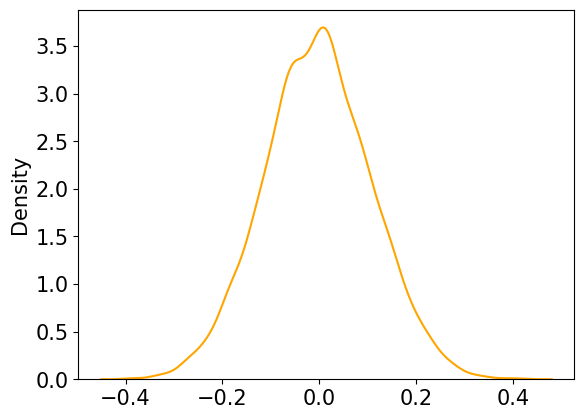

In [32]:
plot_node_feat(actor0_df)

In [33]:
actor1_df = pd.DataFrame(nodefeature_dict[class1_graphid]['actor'].numpy())
print_stat_cont_features(actor1_df)

mean -0.00078882417
std dev 0.11530116


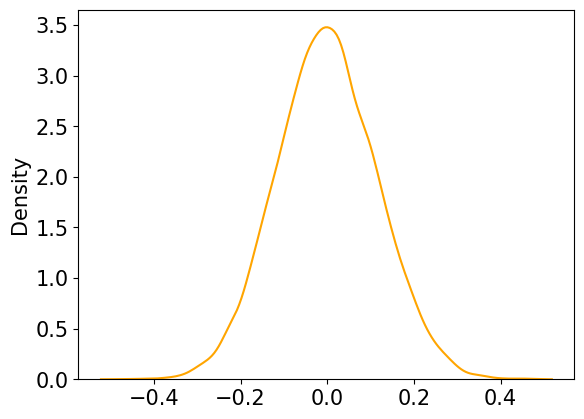

In [34]:
plot_node_feat(actor1_df)

In [35]:
actor2_df = pd.DataFrame(nodefeature_dict[class2_graphid]['actor'].numpy())
print_stat_cont_features(actor2_df)

mean -0.00018114649
std dev 0.104094155


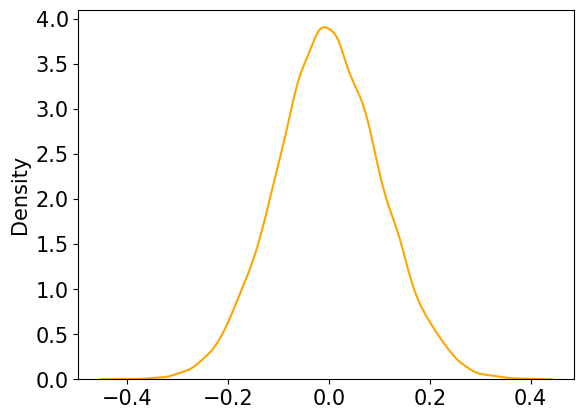

In [36]:
plot_node_feat(actor2_df)

In [37]:
#Director
director0_df = pd.DataFrame(nodefeature_dict[class0_graphid]['director'].numpy())
print_stat_cont_features(director0_df)

mean 0.0011952851
std dev 0.11101871


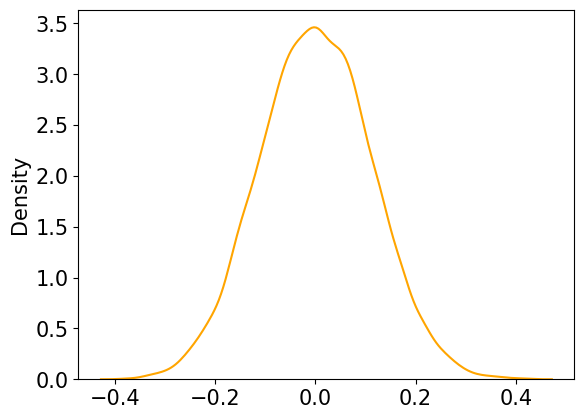

In [38]:
plot_node_feat(director0_df)

In [41]:
director2_df = pd.DataFrame(nodefeature_dict[class2_graphid]['director'].numpy())
print_stat_cont_features(director2_df)

mean 0.00029307787
std dev 0.104507186


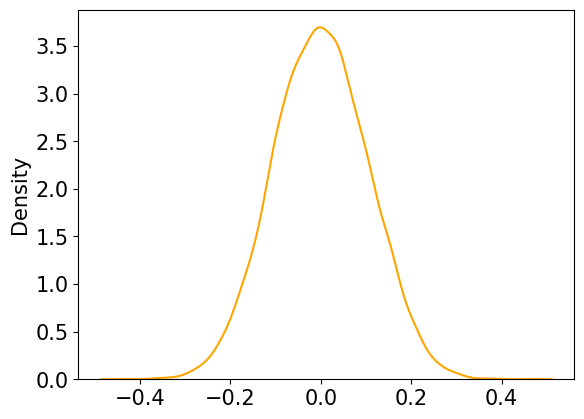

In [42]:
plot_node_feat(director2_df)